In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from enbed.utils.batcher import batch_provider
from enbed.utils import conv
from enbed.models import Energy_Diag_Scorer as scorer
from enbed.training import train_energy as train

import numpy as np
import torch
import seaborn as sns

**Define some convenience functions for plotting later**

In [2]:
def get_scores(model, triples):
    scores = model.prob(triples[:,0], triples[:,1], triples[:,2]).detach().numpy()
    return scores
            
def draw_plot(triples_named, labels, scores, case, ax, colors):
    labs, scs= [], []

    train_sc = []
    for i in range(len(triples_named)):
        if labels[i] == 4:
            train_sc.append(scores[i])
        else:
            labs.append(labels[i])
            scs.append(scores[i])
    labs.append(4)
    scs.append(np.mean(train_sc))
    labs = np.array(labs)
    scs = np.array(scs)

    markers = ['1', 'x', '.', '+', '*']
    x0 = 0
    totallen = 0
    for i in range(5):
        totallen += len(scs[labs==i])
    for i in range(5):
        if i in labs:
            s1 = scs[labs==i]
            xran = np.arange(x0, x0+len(s1))
            idorder = np.argsort(s1)
            marker = markers[i]
            msize = 7
            color = colors[i]
            ax.plot(xran, s1[idorder], marker = marker, markersize=msize, linewidth=0, color = color)
            x0 += len(s1)+0.065*totallen
    ax.set_ylim(0.,1.05)
    sns.despine(ax = ax)
    ax.set_xticks([])
    paneltitles = {
        'variables_access': 'Variable access',
        'ssh': 'SSH access',
        'https': 'HTTPS access',
        'scan': 'Network scan',
        'credential_use': 'Credential use',
        'init': 'PLC start-up',
    }
    ax.set_title(paneltitles[case], y=0.96, fontsize=10)
    
def draw_subplot(triples_named, labels, scores, whichones, names, case, ax, colors):
    for l in range(len(ax)):
        if l < len(whichones):
            labs, scs = [], []

            train_sc = []
            for i in range(len(triples_named)):
                if whichones[l] in triples_named[i][0]:
                    if labels[i] == 4:
                        train_sc.append(scores[i])
                    else:
                        labs.append(labels[i])
                        scs.append(scores[i])
            labs.append(4)
            scs.append(np.mean(train_sc))
            labs = np.array(labs)
            scs = np.array(scs)

            markers = ['1', 'x', '.', '+', '*']
            x0 = 0
            totallen = 0
            for i in range(5):
                totallen += len(scs[labs==i])
            for i in range(5):
                if i in labs:
                    s1 = scs[labs==i]
                    xran = np.arange(x0, x0+len(s1)-0.001)
                    idorder = np.argsort(s1)
                    marker = markers[i]#'x'
                    msize = 7
                    ax[l].plot(xran, s1[idorder], marker = marker, markersize=msize, linewidth=0, color = colors[i])
                    x0 += len(s1)+0.1*totallen
            ax[l].set_ylim(0.,1.05)
            sns.despine(ax = ax[l])
            ax[l].set_title(names[l], y=0.97, fontsize=10)
            ax[l].set_xticks([])
        else:
            sns.despine(ax= ax[l], bottom=True, top=True, left=True, right=True)
            ax[l].set_xticks([])
            ax[l].set_yticks([])

**Train the model on the baseline**

In [3]:
params = {
    'dim': 20,
    'lr': 0.02,
    'L2': 0.001,
    'sample_steps': 20, #20
    'steps': 8001,
    'batchsize': 100,
}
path = '../data/Industrial_Automation--Cybersecurity'
np.random.seed(12312345)
seeds = np.random.randint(1e8, size=10)

In [4]:
datapath = '{}/training'.format(path)
train_data, num_nodes, num_predicates = conv.load_data(datapath)

In [5]:
seed = 66977865
batcher = batch_provider(train_data, params['batchsize'], 0, seed)
model = scorer(num_nodes, num_predicates, params['dim'], seed)
model.entities.weight.data *= 0.1
model.predicates.weight.data *= 0.1
optimizer = torch.optim.Adagrad([model.entities.weight, model.predicates.weight], lr=params['lr'], weight_decay = params['L2'])
train(optimizer, batcher, model, params['sample_steps'], params['steps'])

**Evaluate model on the benchmarks**

Labels are: highly suspicious (red, Y), suspicious (orange, x), unexpected (magenta, o), expected (blue, +) and observed during training (black, *).

On the x-axis, individual triple events are shown. Higher values indicate that the model regards a triple to be more plausible (i.e., less suspicious).

(a) shows the results for all benchmarks. (b) shows the results of a single benchmark for triple activity from a single device, like an edge or dev machine.

<IPython.core.display.Javascript object>


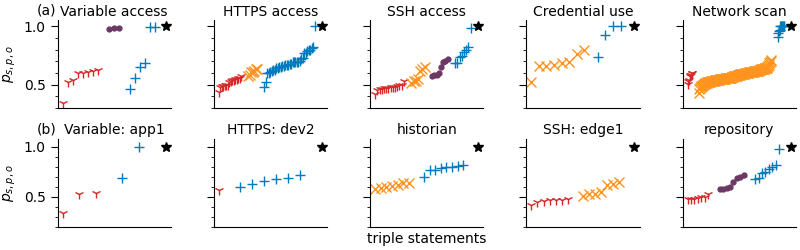

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2.5))
gs = fig.add_gridspec(6, 10, wspace = .15, hspace=-.5)

axlab2 = fig.add_subplot(gs[:3, 0:])
sns.despine(ax=axlab2, bottom=True, left=True, right=True,top=True)
axlab2.set_xticks([])
axlab2.set_yticks([])

axlab3 = fig.add_subplot(gs[3:, 0:])
sns.despine(ax=axlab3, bottom=True, left=True, right=True,top=True)
axlab3.set_xticks([])
axlab3.set_yticks([])

ax2 = fig.add_subplot(gs[:3, :2])
ax3 = fig.add_subplot(gs[:3, 2:4])
ax4 = fig.add_subplot(gs[:3, 4:6])
ax5 = fig.add_subplot(gs[:3, 6:8])
ax6 = fig.add_subplot(gs[:3, 8:10])

ax8 = fig.add_subplot(gs[3:, :2])
ax9 = fig.add_subplot(gs[3:, 2:4])
ax10 = fig.add_subplot(gs[3:, 4:6])
ax11 = fig.add_subplot(gs[3:, 6:8])
ax12 = fig.add_subplot(gs[3:, 8:])

colors = ["#D62828","#FF931F","#6D3764","#007CBE", 'k']
ax = [ax2, ax3, ax4, ax5, ax6]
cases = ['variables_access', 'https', 'ssh', 'credential_use', 'scan']
for i in range(len(cases)):
    triples, triples_named, labels = conv.load_test('{}/test'.format(path), cases[i])
    scores = get_scores(model, triples)
    draw_plot(triples_named, labels, scores, cases[i], ax[i], colors)

for ax in [ax2, ax3, ax4, ax5, ax6]:
    sns.despine(ax=ax)
    ax.set_yticks(np.arange(0,1.01,0.1), minor = True)
    ax.set_yticks([0, 0.5, 1.])
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', length=2.5)
    ax.set_yticklabels([0,0.5, 1.])
    ax.set_xticks([])
    ax.set_ylim(0.3,1.05)
for ax in [ax3, ax4, ax5, ax6]:
    ax.set_yticklabels([])
    

cases = ['variables_access', 'https', 'ssh']#, 'ssh', 'internet', 'scan']
whichones = [['app1'],
             ['192.168.0.81', '192.168.0.70'], ['192.168.0.17', '192.168.0.55']]
names = [['Variable: app1'],
         ['HTTPS: dev2', 'historian'],
        ['SSH: edge1', 'repository']]

ax = [[ax8],
     [ax9, ax10], [ax11, ax12]]

for i in range(len(cases)):
    triples, triples_named, labels = conv.load_test('{}/test'.format(path), cases[i])
    scores = get_scores(model, triples)
    draw_subplot(triples_named, labels, scores, whichones[i], names[i], cases[i], ax[i], colors)
             
markers = ['1', '2', '3', '+', 'x', '*']

for ax in [ax8,ax9,ax10,ax11,ax12]:
    ax.set_ylim(0,1.1)
    ax.set_yticks(np.arange(0,1.01,0.1), minor = True)
    ax.set_yticks([0, 0.5, 1.])
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', length=2.5)
    ax.set_yticklabels([])
    ax.set_ylim(0.2,1.075)
for ax in [ax8]:
    ax.set_yticklabels([0, 0.5, 1.0])

axlab2.set_title('(a)', fontsize=10, x=-0.015, y=0.97)
axlab3.set_title('(b)', fontsize=10, x=-0.015, y=0.97)
ax10.set_xlabel('triple statements', fontsize = 10)
ax2.set_ylabel('$p_{s,p,o}$', fontsize = 10)
_ = ax8.set_ylabel('$p_{s,p,o}$', fontsize = 10)